In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels as sm
import warnings

In [2]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import brier_score_loss, mean_squared_error
from sklearn.decomposition import PCA

In [3]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

In [4]:
from sklearn.feature_selection import RFECV

In [5]:
df = pd.read_csv('battle_data.csv')
df2 = df.drop(columns = ['Year/Month', 'Unnamed: 0'])
df3 = pd.get_dummies(df2, columns = ['Country_Code', 'month'])
df3['lag_fatal_1'] = df3['fatalities'].shift(4) # Add three month lag - Found in Tuning Notebook
df3['lag_fatal_2'] = df3['fatalities'].shift(8) # Add three month lag - Found in Tuning Notebook
df3['lag_fatal_3'] = df3['fatalities'].shift(12) # Add three month lag - Found in Tuning Notebook
df3.lag_fatal_1[0:4] = [68,0,15,47] # Add missing values (33,0,97,172,52,0,6,73,) <-- Add to front for more months
df3.lag_fatal_2[0:8] = [52,0,6,73,68,0,15,47]
df3.lag_fatal_3[0:12] = [33,0,97,172,52,0,6,73,68,0,15,47]

X = df3.drop(columns = 'fatalities')
y = df3.fatalities
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1, random_state=0)
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]

X_pred = X[-60:-56]
y_pred = y[-60:-56]

C:\Users\ssq10\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\ssq10\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ssq10\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_pred = scaler.transform(X_pred)
X2 = scaler.fit_transform(X)

In [7]:
NB = BayesianRidge(alpha_1=.01,alpha_2=100)
NB.fit(X_train,y_train)

BayesianRidge(alpha_1=0.01, alpha_2=100, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [8]:
pred = NB.predict(X_test)
mean_squared_error(y_test,pred)

4186.2641271781395

In [9]:
import_df = pd.DataFrame({'NB Coefs':NB.coef_},index = X.columns)
coef_df = import_df.sort_values('NB Coefs', ascending=False)

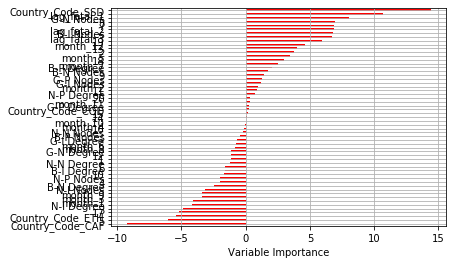

In [10]:
coef_df.plot.barh(color='r').invert_yaxis()
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.grid()

In [11]:
coef_df[-6:]

,NB Coefs
N-I Degree,-4.156435
3,-4.834141
17,-5.144866
Country_Code_ETH,-5.404967
5,-6.010399
Country_Code_CAF,-9.252801


In [12]:
RR = Ridge(alpha=24.77,random_state=0)
RR.fit(X_train,y_train)

Ridge(alpha=24.77, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=0, solver='auto', tol=0.001)

In [13]:
pred = RR.predict(X_test)
mean_squared_error(y_test,pred)

4902.0457433908305

In [14]:
import_df = pd.DataFrame({'RR Coefs':RR.coef_},index = X.columns)
coef_df['RR Coefs'] = import_df.sort_values('RR Coefs', ascending=False)

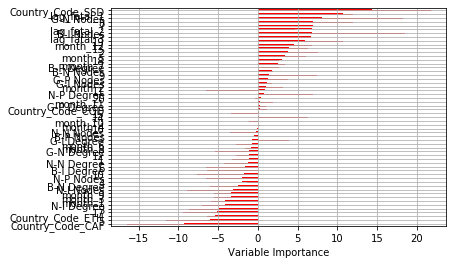

In [15]:
coef_df.plot.barh(color='r').invert_yaxis()
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.grid()

In [16]:
Lasso = Lasso(alpha=8.11,random_state=0)
Lasso.fit(X_train,y_train)

Lasso(alpha=8.11, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False)

In [17]:
pred = Lasso.predict(X_test)
mean_squared_error(y_test,pred)

5942.024414166011

In [18]:
import_df = pd.DataFrame({'RR Coefs':Lasso.coef_},index = X.columns)
coef_df['Lasso Coefs'] = import_df.sort_values('RR Coefs', ascending=False)

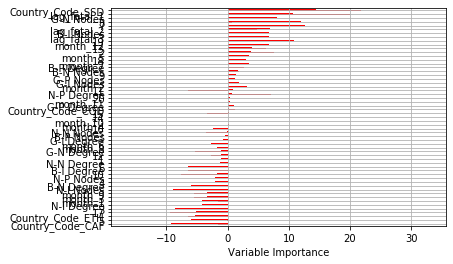

In [19]:
coef_df.plot.barh(color='r').invert_yaxis()
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.grid()

In [20]:
RF = RandomForestRegressor(n_estimators = 80,max_features = 10, max_depth = 6,random_state=0)
RF.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features=10, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=80,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [21]:
pred = RF.predict(X_test)
mean_squared_error(y_test,pred)

5578.0698475707495

In [22]:
mean_squared_error(y_test,[y_train.mean()]*len(y_test))

6908.264195419394

In [23]:
Importance = pd.DataFrame({'RF Import':RF.feature_importances_*100},
                         index = X.columns)
Import_df =Importance.sort_values('RF Import', ascending=False)[:5] # Display Top 15

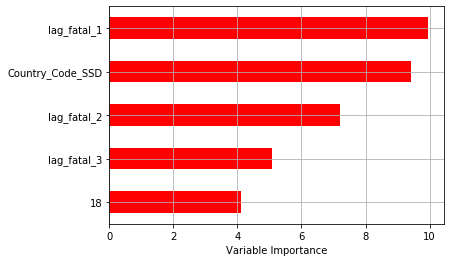

In [24]:
Import_df.plot.barh(color='r').invert_yaxis()
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.grid()

In [25]:
AB = AdaBoostRegressor(n_estimators=100, learning_rate=.05,random_state=0)
AB.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=0.05, loss='linear',
                  n_estimators=100, random_state=0)

In [26]:
pred = AB.predict(X_test)
mean_squared_error(y_test,pred)

7291.973467380044

In [27]:
mean_squared_error(y_test,[y_train.mean()]*len(y_test))

6908.264195419394

In [28]:
Importance = pd.DataFrame({'AB Import':AB.feature_importances_*100},
                         index = X.columns)
Import_df['Ab Import'] =Importance.sort_values('AB Import', ascending=False)[:5] # Display Top 10

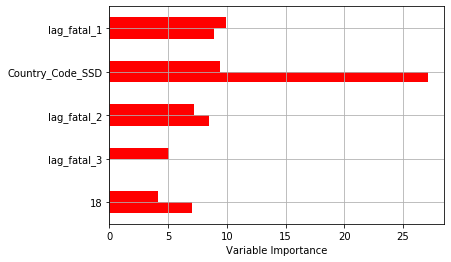

In [29]:
Import_df.plot.barh(color='r').invert_yaxis()
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.grid()

In [30]:
XGB = XGBRegressor(n_estimators=30, learning_rate=.06,random_state=0,objective ='reg:squarederror')
XGB.fit(X_train,y_train)

C:\Users\ssq10\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ssq10\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.06, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=30,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [31]:
pred = XGB.predict(X_test)
mean_squared_error(y_test,pred)

7262.067818266875

In [32]:
mean_squared_error(y_test,[y_train.mean()]*len(y_test))

6908.264195419394

In [33]:
Importance = pd.DataFrame({'XGB Import':XGB.feature_importances_*100},
                         index = X.columns)
Import_df['XGB Import']=Importance.sort_values('XGB Import', ascending=False)[:5] # Display Top 10

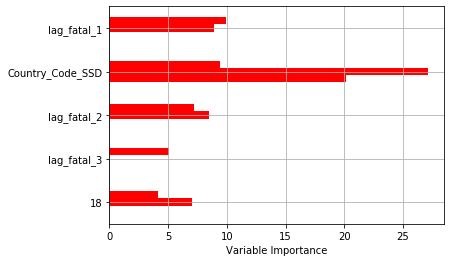

In [34]:
Import_df.plot.barh(color='r').invert_yaxis()
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.grid()

In [35]:
#NB = BayesianRidge(alpha_1=.01,alpha_2=100)
AB = AdaBoostRegressor(n_estimators=100, learning_rate=.05,random_state=0)
selector = RFECV(AB, step=1, cv=10, scoring='r2')
selector.fit(X,y)

RFECV(cv=10,
      estimator=AdaBoostRegressor(base_estimator=None, learning_rate=0.05,
                                  loss='linear', n_estimators=100,
                                  random_state=0),
      min_features_to_select=1, n_jobs=None, scoring='r2', step=1, verbose=0)

In [36]:
selector.support_

array([ True, False,  True,  True, False, False, False,  True,  True,
        True, False, False, False, False,  True, False,  True, False,
        True,  True, False, False, False,  True,  True,  True,  True,
        True, False,  True,  True, False, False,  True, False,  True,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True])

In [37]:
selector.ranking_

array([ 1,  2,  1,  1,  4,  8, 18,  1,  1,  1, 11,  3, 16, 13,  1,  5,  1,
        7,  1,  1, 20,  6, 14,  1,  1,  1,  1,  1, 19,  1,  1, 10, 12,  1,
        9,  1, 15,  1, 30, 31, 33,  1, 34, 29, 28, 32, 21, 24, 17, 25, 26,
       27, 22, 23,  1,  1,  1])

In [38]:
selector.grid_scores_

array([ 0.03019719, -0.04034048,  0.08626326,  0.12614772,  0.14903495,
        0.19447981,  0.19297668,  0.21277788,  0.20484519,  0.07642474,
        0.07862424,  0.08463616,  0.07603712,  0.13141706,  0.09156344,
        0.06298006,  0.08439764,  0.06079523,  0.0974239 ,  0.07143416,
        0.06269949,  0.06413193,  0.08759101,  0.2164206 ,  0.08371293,
        0.09567386,  0.07397282,  0.13087899,  0.09979348,  0.08746291,
        0.18957962,  0.0682104 ,  0.07636626,  0.21151994,  0.17073383,
        0.21084459,  0.21122192,  0.15182215,  0.18876109,  0.1484347 ,
        0.15275042,  0.16003393,  0.1911057 ,  0.18928492,  0.1348261 ,
        0.09193921,  0.21135664,  0.13958801,  0.20180712,  0.17206474,
        0.11019394,  0.20622589,  0.20758378,  0.16765158,  0.07041301,
        0.08388057,  0.19544793])

In [39]:
max(selector.grid_scores_)

0.21642059660225219

In [40]:
ranking = selector.ranking_
scores = selector.grid_scores_
var = np.array(X.columns)

In [41]:
feat_df = pd.DataFrame()
feat_df['Feature'] = var
feat_df['Rank'] = ranking
feat_df['-MSE'] = scores

In [42]:
feat_df.sort_values('Rank', ascending=True)

,Feature,Rank,-MSE
0,G-P Nodes,1,0.030197
54,lag_fatal_1,1,0.070413
41,Country_Code_SSD,1,0.160034
37,20,1,0.151822
35,18,1,0.210845
33,16,1,0.211520
30,13,1,0.189580
29,12,1,0.087463
55,lag_fatal_2,1,0.083881
27,10,1,0.130879


In [43]:
coef_df.dropna()

,NB Coefs,RR Coefs,Lasso Coefs
Country_Code_SSD,14.421999,21.805223,33.238255
lag_fatal_1,10.679929,11.948381,20.054396
G-N Nodes,8.027239,18.276553,0.000000
8,6.961810,12.018443,0.629776
7,6.887636,12.571446,0.069912
lag_fatal_2,6.858088,4.722951,5.508723
B-I Nodes,6.772106,18.590246,0.000000
lag_fatal_3,6.754633,6.704420,0.000000
19,5.912642,10.760197,0.000000
month_12,4.581826,6.785229,0.000000


In [44]:
coef_df['Average'] = coef_df.mean(axis=1)
coef_df['NB Coefs'].sort_values('Average', ascending=True)

ValueError: No axis named Average for object type <class 'pandas.core.series.Series'>

In [ ]:
Import_df['Average'] = Import_df.mean(axis=1)
Import_df.sort_values('Average', ascending=False)